# **Importing Libraries**

In [ ]:
pip install pandas numpy matplotlib

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# **Load Data**

In [3]:
# Paths to the main folders
baseline_path = 'Dataset/Baseline_CMT1A-BioStampNPoint2023'
longitudinal_path = 'Dataset/Longitudinal_CMT1A-BioStampNPoint2023'

**Preprocessing**

In [4]:
data_dict = {}

def load_participant_data(participant_folder, participant_path):
    try:
       # annot_file = pd.read_csv(os.path.join(participant_path, f'AnnotID_{participant_folder}.csv'))
        ch_file = pd.read_csv(os.path.join(participant_path, f'ch_ID_{participant_folder}_Accel.csv'))
        ll_file = pd.read_csv(os.path.join(participant_path, f'll_ID_{participant_folder}_Accel.csv'))
        lt_file = pd.read_csv(os.path.join(participant_path, f'lt_ID_{participant_folder}_Accel.csv'))

        return {
           # 'annotations': annot_file,
            'chest': ch_file,
            'left_limb': ll_file,
            'left_thigh': lt_file
        }
    except Exception as e:
        print(f'Error loading data for {participant_folder}: {e}')
        return None

for main_folder in [baseline_path, longitudinal_path]:
    for participant_folder in os.listdir(main_folder):
        participant_path = os.path.join(main_folder, participant_folder)
        if os.path.isdir(participant_path):
            data = load_participant_data(participant_folder, participant_path)
            if data:
                data_dict[participant_folder] = data

**Missing File Checking**

In [5]:
missing_files = []
for participant_folder in data_dict.keys():
    files = data_dict[participant_folder].keys()
    expected_files = ['chest', 'left_limb', 'left_thigh']
    for file_type in expected_files:
        if file_type not in files:
            missing_files.append((participant_folder, file_type))

# Display any missing files
if missing_files:
    print('Missing files:')
    for participant_folder, file_type in missing_files:
        print(f'{file_type} missing for participant {participant_folder}')
else:
    print('All files are accounted for.')

All files are accounted for.


In [6]:
for participant, files in data_dict.items():
    print(f'Participant: {participant}')
    for file_type, df in files.items():
        print(f'  {file_type}: {df.shape}')

Participant: ROC-008
  chest: (2861280, 4)
  left_limb: (10393680, 4)
  left_thigh: (10393680, 4)
Participant: ROC-011
  chest: (2903840, 4)
  left_limb: (10393680, 4)
  left_thigh: (10393680, 4)
Participant: ROC-016
  chest: (2856920, 4)
  left_limb: (10393680, 4)
  left_thigh: (10393680, 4)
Participant: ROC-017
  chest: (2863600, 4)
  left_limb: (10393680, 4)
  left_thigh: (10393680, 4)
Participant: ROC-021
  chest: (2867080, 4)
  left_limb: (10393680, 4)
  left_thigh: (10393680, 4)
Participant: ROC-023
  chest: (2908520, 4)
  left_limb: (10393680, 4)
  left_thigh: (10393680, 4)
Participant: ROC-024
  chest: (2865440, 4)
  left_limb: (10393680, 4)
  left_thigh: (10393680, 4)
Participant: ROC-028
  chest: (67840, 4)
  left_limb: (59760, 4)
  left_thigh: (62040, 4)
Participant: ROC-029
  chest: (2863720, 4)
  left_limb: (10393680, 4)
  left_thigh: (10393680, 4)
Participant: ROC-032
  chest: (2869680, 4)
  left_limb: (10393680, 4)
  left_thigh: (10393680, 4)
Participant: ROC-033
  chest

# **Data Align and Merge**

**Remove Duplicate Timestamps and Align Sensor Data**

In [7]:
# Function to remove duplicates and align sensor data based on timestamps
def align_and_merge_sensor_data(ch_df, ll_df, lt_df):
    # Remove duplicates from each DataFrame based on the timestamp column
    ch_df = ch_df.drop_duplicates(subset=['Timestamp (microseconds)'])
    ll_df = ll_df.drop_duplicates(subset=['Timestamp (microseconds)'])
    lt_df = lt_df.drop_duplicates(subset=['Timestamp (microseconds)'])

    # Get a common timestamp range by taking the union of all timestamps
    common_timestamps = np.unique(np.concatenate([
        ch_df['Timestamp (microseconds)'], 
        ll_df['Timestamp (microseconds)'], 
        lt_df['Timestamp (microseconds)']
    ]))

    # Set the timestamp as the index for each DataFrame
    ch_df.set_index('Timestamp (microseconds)', inplace=True)
    ll_df.set_index('Timestamp (microseconds)', inplace=True)
    lt_df.set_index('Timestamp (microseconds)', inplace=True)
    
    # Reindex each DataFrame to the common timestamps
    ch_df_aligned = ch_df.reindex(common_timestamps).ffill().bfill()
    ll_df_aligned = ll_df.reindex(common_timestamps).ffill().bfill()
    lt_df_aligned = lt_df.reindex(common_timestamps).ffill().bfill()

    # Reset index to make 'Timestamp (microseconds)' a column again
    ch_df_aligned.reset_index(inplace=True)
    ll_df_aligned.reset_index(inplace=True)
    lt_df_aligned.reset_index(inplace=True)

    return ch_df_aligned, ll_df_aligned, lt_df_aligned


**Merge the Aligned Sensor Data**

In [8]:
# Function to merge aligned sensor data
def merge_aligned_sensor_data(ch_df_aligned, ll_df_aligned, lt_df_aligned):
    # Merge the DataFrames on the timestamp column
    merged_df = ch_df_aligned.merge(ll_df_aligned, on='Timestamp (microseconds)', suffixes=('_chest', '_left_limb'))
    merged_df = merged_df.merge(lt_df_aligned, on='Timestamp (microseconds)', suffixes=('', '_left_thigh'))

    # Rename columns for clarity
    merged_df.rename(columns={
        'Accel X (g)': 'Accel X (g)_left_thigh',
        'Accel Y (g)': 'Accel Y (g)_left_thigh',
        'Accel Z (g)': 'Accel Z (g)_left_thigh'
    }, inplace=True)
    
    return merged_df

**Process All Participants**

In [9]:
# Loop through each participant and align and merge their sensor data
merged_data = {}

for participant_folder in data_dict.keys():
    # Get sensor data
    ch_df = data_dict[participant_folder]['chest']
    ll_df = data_dict[participant_folder]['left_limb']
    lt_df = data_dict[participant_folder]['left_thigh']
    
    # Align sensor data based on timestamps
    ch_df_aligned, ll_df_aligned, lt_df_aligned = align_and_merge_sensor_data(ch_df, ll_df, lt_df)
    
    # Merge aligned sensor data
    merged_df = merge_aligned_sensor_data(ch_df_aligned, ll_df_aligned, lt_df_aligned)
    
    # Store the merged data for the participant
    merged_data[participant_folder] = merged_df
    
    print(f"Processed sensor data for participant: {participant_folder}")

# Example: Display the merged data for one participant
participant_id = list(merged_data.keys())[0]
print(f"Merged data for {participant_id}:")
print(merged_data[participant_id].head())

Processed sensor data for participant: ROC-008
Processed sensor data for participant: ROC-011
Processed sensor data for participant: ROC-016
Processed sensor data for participant: ROC-017
Processed sensor data for participant: ROC-021
Processed sensor data for participant: ROC-023
Processed sensor data for participant: ROC-024
Processed sensor data for participant: ROC-028
Processed sensor data for participant: ROC-029
Processed sensor data for participant: ROC-032
Processed sensor data for participant: ROC-033
Processed sensor data for participant: ROC-034
Processed sensor data for participant: ROC-037
Processed sensor data for participant: ROC-041
Processed sensor data for participant: ROC-042
Processed sensor data for participant: ROC-048
Processed sensor data for participant: ROC-101
Processed sensor data for participant: ROC-102
Processed sensor data for participant: ROC-103
Processed sensor data for participant: ROC-104
Processed sensor data for participant: ROC-105
Processed sen

**Visualize Data**

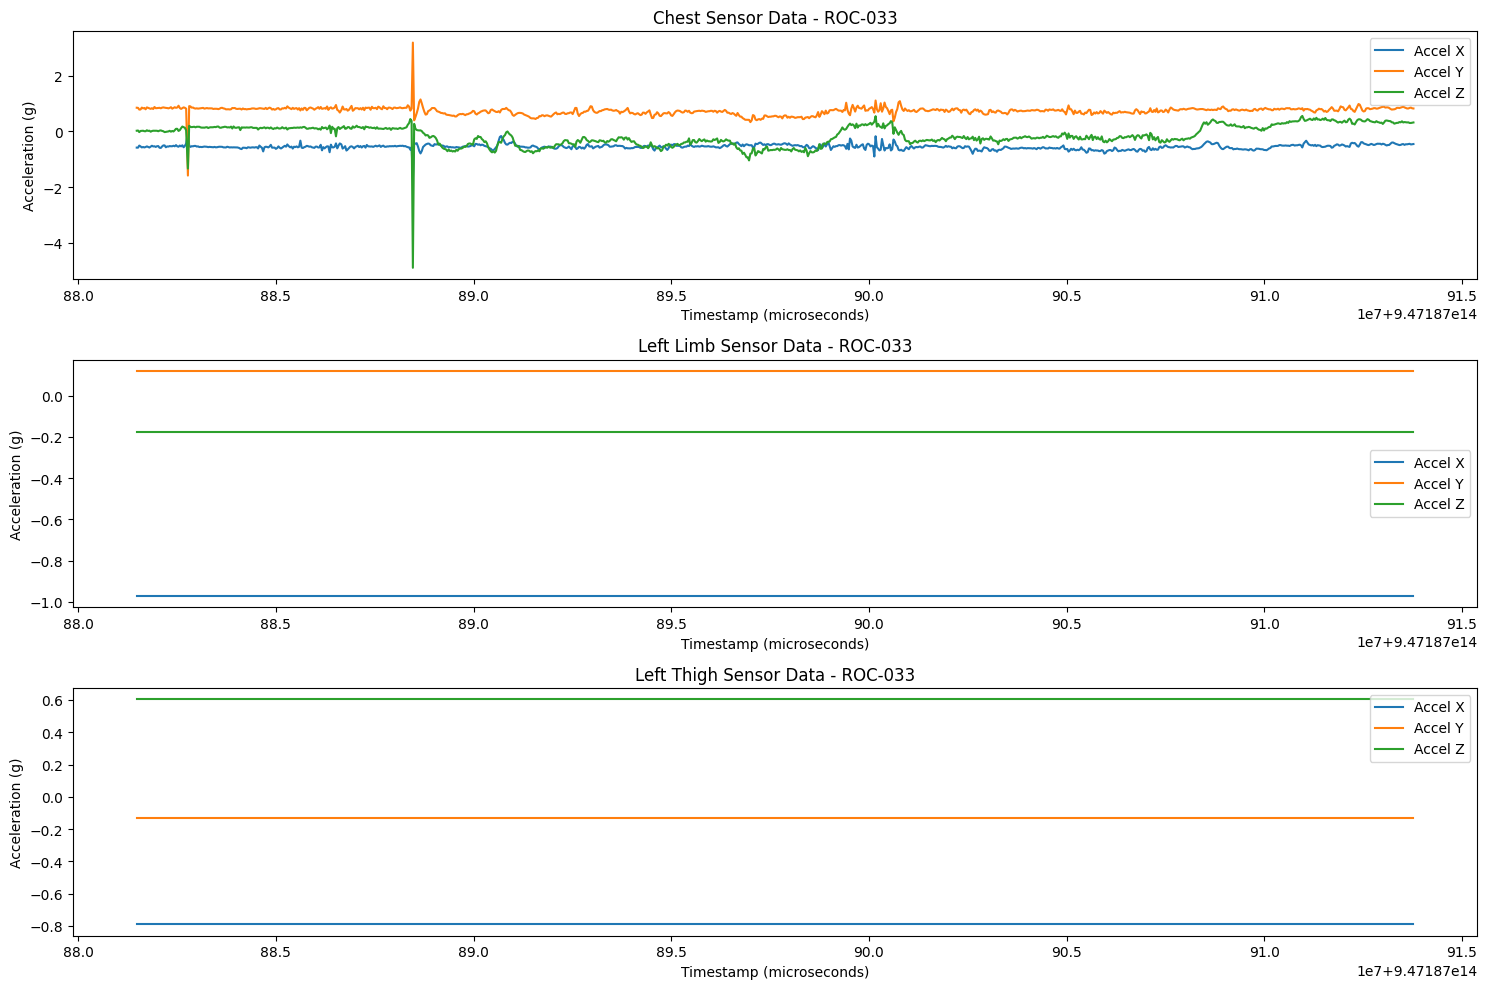

In [10]:
def plot_combined_sensor_data(merged_df, participant_id, start=0, end=1000):
    # Subset the data for visualization clarity
    plot_data = merged_df.iloc[start:end]

    plt.figure(figsize=(15, 10))
    
    # Plot chest sensor data
    plt.subplot(3, 1, 1)
    plt.plot(plot_data['Timestamp (microseconds)'], plot_data['Accel X (g)_chest'], label='Accel X')
    plt.plot(plot_data['Timestamp (microseconds)'], plot_data['Accel Y (g)_chest'], label='Accel Y')
    plt.plot(plot_data['Timestamp (microseconds)'], plot_data['Accel Z (g)_chest'], label='Accel Z')
    plt.title(f'Chest Sensor Data - {participant_id}')
    plt.xlabel('Timestamp (microseconds)')
    plt.ylabel('Acceleration (g)')
    plt.legend()

    # Plot left limb sensor data
    plt.subplot(3, 1, 2)
    plt.plot(plot_data['Timestamp (microseconds)'], plot_data['Accel X (g)_left_limb'], label='Accel X')
    plt.plot(plot_data['Timestamp (microseconds)'], plot_data['Accel Y (g)_left_limb'], label='Accel Y')
    plt.plot(plot_data['Timestamp (microseconds)'], plot_data['Accel Z (g)_left_limb'], label='Accel Z')
    plt.title(f'Left Limb Sensor Data - {participant_id}')
    plt.xlabel('Timestamp (microseconds)')
    plt.ylabel('Acceleration (g)')
    plt.legend()

    # Plot left thigh sensor data
    plt.subplot(3, 1, 3)
    plt.plot(plot_data['Timestamp (microseconds)'], plot_data['Accel X (g)_left_thigh'], label='Accel X')
    plt.plot(plot_data['Timestamp (microseconds)'], plot_data['Accel Y (g)_left_thigh'], label='Accel Y')
    plt.plot(plot_data['Timestamp (microseconds)'], plot_data['Accel Z (g)_left_thigh'], label='Accel Z')
    plt.title(f'Left Thigh Sensor Data - {participant_id}')
    plt.xlabel('Timestamp (microseconds)')
    plt.ylabel('Acceleration (g)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the combined sensor data for a specific participant
participant_id = list(merged_data.keys())[10]  # Example: Choose the first participant
plot_combined_sensor_data(merged_data[participant_id], participant_id, start=0, end=1000)

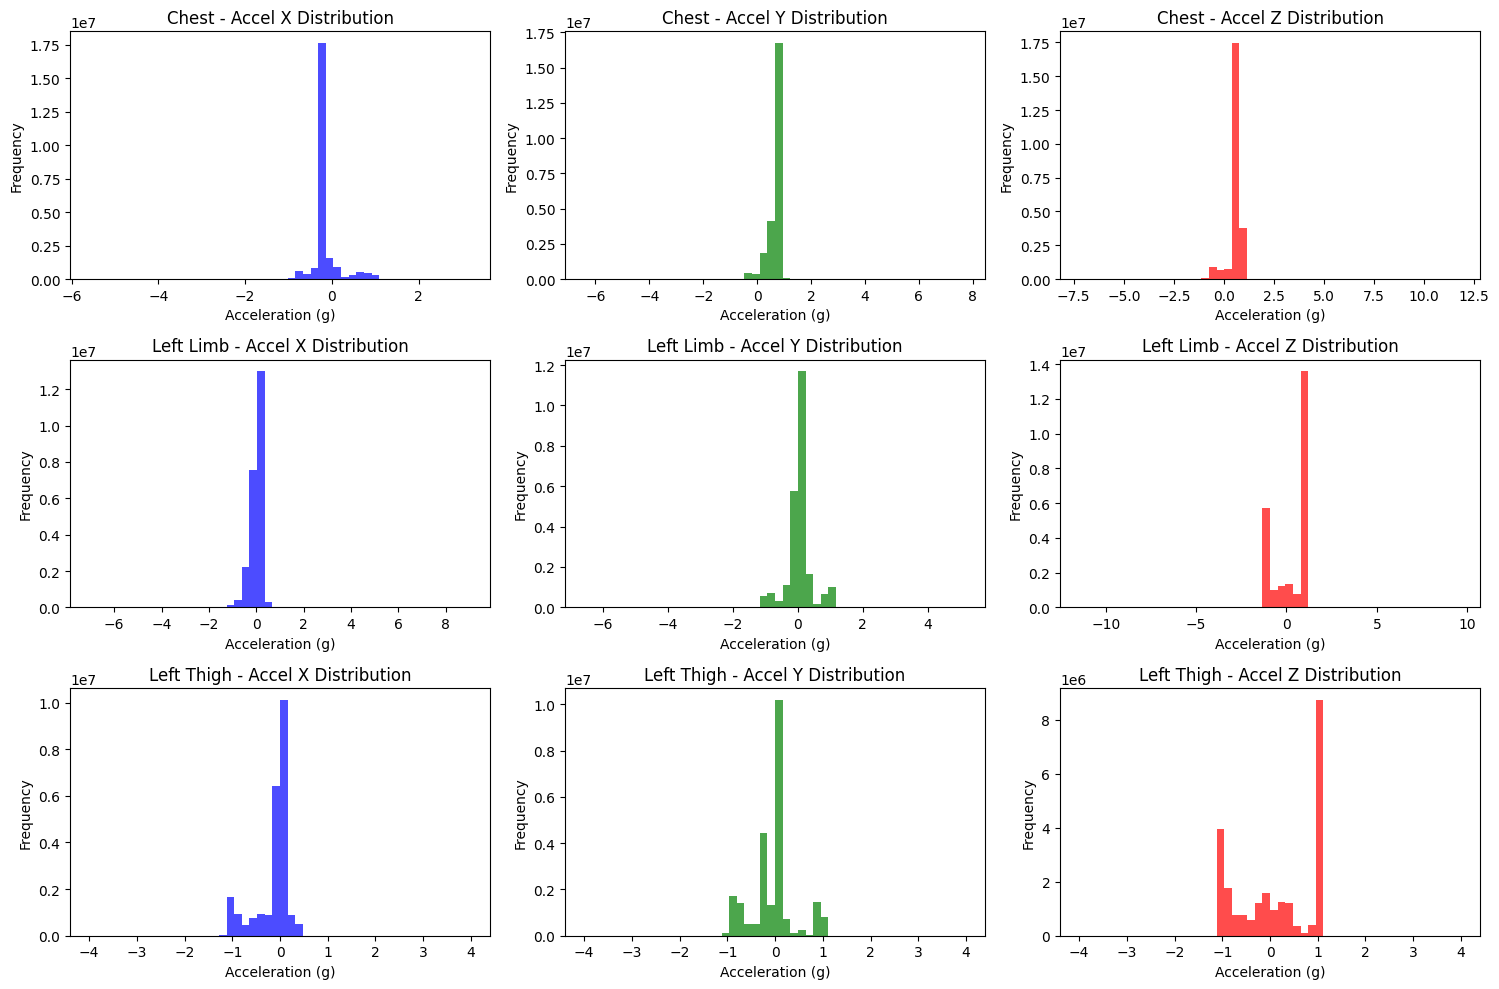

In [11]:
# Function to plot the distribution of acceleration data for a participant
def plot_acceleration_distribution(merged_df, participant_id):
    plt.figure(figsize=(15, 10))

    # Chest sensor data distribution
    plt.subplot(3, 3, 1)
    plt.hist(merged_df['Accel X (g)_chest'], bins=50, alpha=0.7, color='blue')
    plt.title(f'Chest - Accel X Distribution')
    plt.xlabel('Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 2)
    plt.hist(merged_df['Accel Y (g)_chest'], bins=50, alpha=0.7, color='green')
    plt.title(f'Chest - Accel Y Distribution')
    plt.xlabel('Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 3)
    plt.hist(merged_df['Accel Z (g)_chest'], bins=50, alpha=0.7, color='red')
    plt.title(f'Chest - Accel Z Distribution')
    plt.xlabel('Acceleration (g)')
    plt.ylabel('Frequency')

    # Left limb sensor data distribution
    plt.subplot(3, 3, 4)
    plt.hist(merged_df['Accel X (g)_left_limb'], bins=50, alpha=0.7, color='blue')
    plt.title(f'Left Limb - Accel X Distribution')
    plt.xlabel('Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 5)
    plt.hist(merged_df['Accel Y (g)_left_limb'], bins=50, alpha=0.7, color='green')
    plt.title(f'Left Limb - Accel Y Distribution')
    plt.xlabel('Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 6)
    plt.hist(merged_df['Accel Z (g)_left_limb'], bins=50, alpha=0.7, color='red')
    plt.title(f'Left Limb - Accel Z Distribution')
    plt.xlabel('Acceleration (g)')
    plt.ylabel('Frequency')

    # Left thigh sensor data distribution
    plt.subplot(3, 3, 7)
    plt.hist(merged_df['Accel X (g)_left_thigh'], bins=50, alpha=0.7, color='blue')
    plt.title(f'Left Thigh - Accel X Distribution')
    plt.xlabel('Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 8)
    plt.hist(merged_df['Accel Y (g)_left_thigh'], bins=50, alpha=0.7, color='green')
    plt.title(f'Left Thigh - Accel Y Distribution')
    plt.xlabel('Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 9)
    plt.hist(merged_df['Accel Z (g)_left_thigh'], bins=50, alpha=0.7, color='red')
    plt.title(f'Left Thigh - Accel Z Distribution')
    plt.xlabel('Acceleration (g)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example: Visualize the acceleration distribution for one participant
participant_id = list(merged_data.keys())[0]  # Choose the first participant
plot_acceleration_distribution(merged_data[participant_id], participant_id)


# **Outlier Remove**

In [ ]:
pip install scipy

In [12]:
from scipy import stats

In [13]:
def remove_outliers_zscore(df, threshold=3):
    # Identify acceleration columns
    accel_columns = [col for col in df.columns if 'Accel' in col]
    
    # Calculate Z-scores for all acceleration columns
    z_scores = np.abs(stats.zscore(df[accel_columns]))
    
    # Filter rows where any Z-score is greater than the threshold
    df_cleaned = df[(z_scores < threshold).all(axis=1)]
    
    return df_cleaned

# Apply the function to the merged dataset for a specific participant
for participant_id, df in merged_data.items():
    df_cleaned = remove_outliers_zscore(df, threshold=3)
   # print(f"{participant_id} - Rows before: {len(df)}, Rows after: {len(df_cleaned)}")
    # Store cleaned data back if needed
    merged_data[participant_id] = df_cleaned

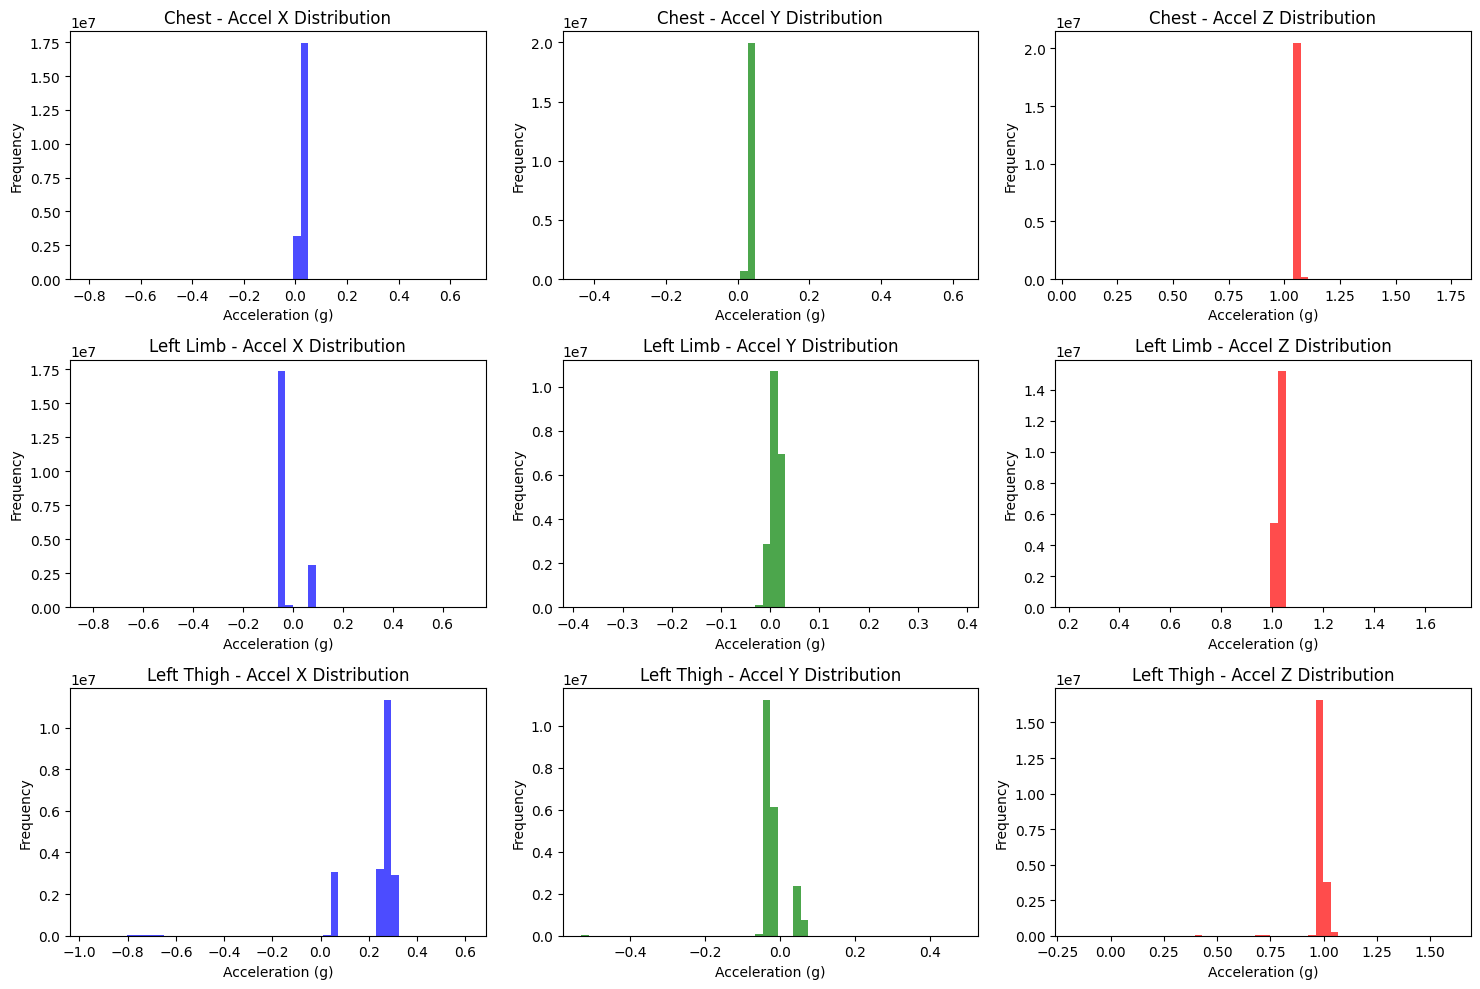

In [14]:
# Plot the cleaned data distribution for a specific participant
plot_acceleration_distribution(df_cleaned, participant_id)

# **DAta Normalization**

In [ ]:
pip install scikit-learn

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def normalize_data_minmax(df):
    # Identify acceleration columns to be normalized
    accel_columns = [col for col in df.columns if 'Accel' in col]
    
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()
    
    # Apply MinMaxScaler to the identified columns
    df[accel_columns] = scaler.fit_transform(df[accel_columns])
    
    return df

# Normalize the cleaned data for all participants
for participant_id in merged_data.keys():
    df_original = merged_data[participant_id]
    
    # Apply normalization to the cleaned data
    df_normalized = normalize_data_minmax(df_original)
    
    # Store the normalized DataFrame back into the merged_data dictionary
    merged_data[participant_id] = df_normalized
    
    print(f"Normalized data for participant: {participant_id}")


In [ ]:
def plot_normalized_acceleration_distribution(df, participant_id):
    plt.figure(figsize=(15, 10))

    # Chest sensor data distribution
    plt.subplot(3, 3, 1)
    plt.hist(df['Accel X (g)_chest'], bins=50, alpha=0.7, color='blue')
    plt.title(f'Chest - Accel X Distribution (Normalized)')
    plt.xlabel('Normalized Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 2)
    plt.hist(df['Accel Y (g)_chest'], bins=50, alpha=0.7, color='green')
    plt.title(f'Chest - Accel Y Distribution (Normalized)')
    plt.xlabel('Normalized Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 3)
    plt.hist(df['Accel Z (g)_chest'], bins=50, alpha=0.7, color='red')
    plt.title(f'Chest - Accel Z Distribution (Normalized)')
    plt.xlabel('Normalized Acceleration (g)')
    plt.ylabel('Frequency')

    # Left limb sensor data distribution
    plt.subplot(3, 3, 4)
    plt.hist(df['Accel X (g)_left_limb'], bins=50, alpha=0.7, color='blue')
    plt.title(f'Left Limb - Accel X Distribution (Normalized)')
    plt.xlabel('Normalized Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 5)
    plt.hist(df['Accel Y (g)_left_limb'], bins=50, alpha=0.7, color='green')
    plt.title(f'Left Limb - Accel Y Distribution (Normalized)')
    plt.xlabel('Normalized Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 6)
    plt.hist(df['Accel Z (g)_left_limb'], bins=50, alpha=0.7, color='red')
    plt.title(f'Left Limb - Accel Z Distribution (Normalized)')
    plt.xlabel('Normalized Acceleration (g)')
    plt.ylabel('Frequency')

    # Left thigh sensor data distribution
    plt.subplot(3, 3, 7)
    plt.hist(df['Accel X (g)_left_thigh'], bins=50, alpha=0.7, color='blue')
    plt.title(f'Left Thigh - Accel X Distribution (Normalized)')
    plt.xlabel('Normalized Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 8)
    plt.hist(df['Accel Y (g)_left_thigh'], bins=50, alpha=0.7, color='green')
    plt.title(f'Left Thigh - Accel Y Distribution (Normalized)')
    plt.xlabel('Normalized Acceleration (g)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 9)
    plt.hist(df['Accel Z (g)_left_thigh'], bins=50, alpha=0.7, color='red')
    plt.title(f'Left Thigh - Accel Z Distribution (Normalized)')
    plt.xlabel('Normalized Acceleration (g)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Visualize normalized data for each participant
for participant_id, df_normalized in merged_data.items():
    print(f"Visualizing normalized data for participant: {participant_id}")
    plot_normalized_acceleration_distribution(df_normalized, participant_id)

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf

# Function to create a TFRecord example from features
def create_tfrecord_example(features, label=None):
    feature_dict = {
        'features': tf.train.Feature(float_list=tf.train.FloatList(value=features))
    }
    if label is not None:
        feature_dict['label'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return example_proto.SerializeToString()

# Directory to save TFRecord
tfrecord_dir = "processed_tfrecord_data"
os.makedirs(tfrecord_dir, exist_ok=True)

# Create a TFRecord writer
tfrecord_path = os.path.join(tfrecord_dir, "data.tfrecord")
with tf.io.TFRecordWriter(tfrecord_path) as writer:
    for participant_id, df_normalized in merged_data.items():
        # Assuming all columns are features (if you have a label column, separate it out)
        # Flatten each row's features into a list
        for row in df_normalized.values:
            features = row.tolist()
            # Create a TFRecord example (without labels in this example)
            example = create_tfrecord_example(features)
            
            # Write the example to the TFRecord file
            writer.write(example)

print(f"Saved processed data to {tfrecord_path}")